In [9]:
import os  
import numpy as np
from numpy import pi
import matplotlib.pyplot as plt
import scipy as sp
from scipy import sparse 
from mesohops.dynamics.hops_trajectory import HopsTrajectory as HOPS  
from mesohops.dynamics.eom_hops_ksuper import _permute_aux_by_matrix  
from mesohops.dynamics.bath_corr_functions import bcf_exp, bcf_convert_sdl_to_exp  


In [10]:
noise_param = {  

    "SEED": 0,  # This sets the seed for the noise
    "MODEL": "FFT_FILTER", # This sets the noise model to be used
    "TLEN": 500.0, # Units: fs (the total time length of the noise trajectory) 
    "TAU": 1.0, # Units: fs  (the time-step resolution of the noise trajectory
}  

nsite = 2  # The number of pigments in the linear chain we are simulating
e_lambda = 20.0  # The reorganization energy in wavenumbers
gamma = 20.0  # The reorganization timescale in wavenumbers
temp = 295.0  # The temperature in Kelvin
(g_0, w_0) = bcf_convert_sdl_to_exp(e_lambda, gamma, 0.0, temp)  

# Define the L operators |n><n| for each site n  
loperator = np.zeros([2, 2, 2], dtype=np.float64)  
gw_sysbath = []  
lop_list = []  
for i in range(nsite):  
    loperator[i, i, i] = 1.0  
    # Here we apply a short time correction to the correlation function
    # by implementing 2 modes for each pigment: 
    # A Markovian mode and a non-Markovian mode. The Markovian mode is used to cancel the 
    # imaginary part of the non_markovian mode and quickly disappears after short time
    gw_sysbath.append([g_0, w_0])  
    lop_list.append(sp.sparse.coo_matrix(loperator[i]))  
    gw_sysbath.append([-1j * np.imag(g_0), 500.0])  
    lop_list.append(loperator[i])  

In [11]:
# Hamiltonian in wavenumbers
hs = np.zeros([nsite, nsite])  
# Manually set the couplings between pigments. We assume each pigment is isergonic:
# that is, the diagonals of the hamiltonian are all 0.
hs[0, 1] = 15  
hs[1, 0] = 15  
 

# System parameters
sys_param = {  
    "HAMILTONIAN": np.array(hs, dtype=np.complex128),  # the Hamiltonian we constructed
    "GW_SYSBATH": gw_sysbath,  # defines exponential decompositoin of correlation function
    "L_HIER": lop_list,  # list of L operators
    "L_NOISE1": lop_list,  # list of noise params associated with noise1
    "ALPHA_NOISE1": bcf_exp,  # function that calculates correlation function
    "PARAM_NOISE1": gw_sysbath,  # list of noise pararms defining decomposition of noise1
}  


In [12]:
# EOM parameters 
eom_param = {"EQUATION_OF_MOTION": "NORMALIZED NONLINEAR"} # we generally pick normalized nonlinear 
# as it has better convergence properties than the linear eom

# Integration parameters 
integrator_param = {"INTEGRATOR": "RUNGE_KUTTA"}  # We use a Runge-Kutta method for our integrator 

# Initial wave function (in the state basis, we fully populate site 3 and no others)
import time
start = time.time()

psi_0 = np.array([0.0] * nsite)#, dtype=np.complex)  
psi_0[0] = 1.0
# To avoid rounding errors, we normalize the wave function
psi_0 = psi_0 / np.linalg.norm(psi_0)  
t_max = 200.0  # The length of the time axis in fs
t_step = 4.0  # The time resolution in fs
delta = 1e-3 # The bound on derivative error

hops = HOPS(  
    sys_param,  
  noise_param=noise_param, 
  hierarchy_param={"MAXHIER": 10},  
  eom_param=eom_param,  
)  

# Make the HopsTrajectory adaptive, initialize it with the wave function and propagate it to t_max.
hops.make_adaptive(delta/np.sqrt(2), delta/np.sqrt(2))
hops.initialize(psi_0)
hops.propagate(t_max, t_step)

end = time.time()

result = end - start
print(result)

Noise Model initialized with SEED =  0
Integration from  0  to  200.0
Early Integration: Using INCH_WORM
Early Integration: Using INCH_WORM
Early Integration: Using INCH_WORM
Early Integration: Using INCH_WORM
Early Integration: Using INCH_WORM
14.638374328613281


In [13]:
storage = hops.storage

len(storage['psi_traj'])

51

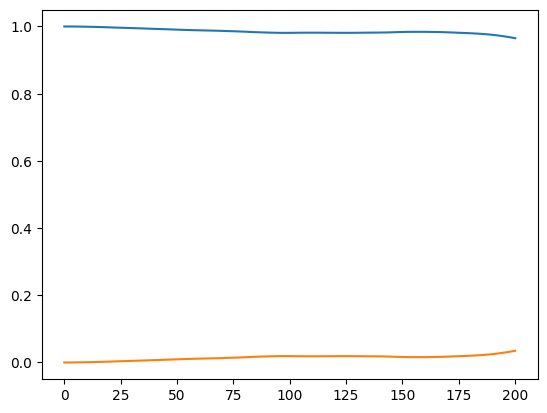

In [14]:
import numpy as np
import matplotlib.pyplot as plt
# gather population and t_axis
pop = np.abs(storage['psi_traj'])**2
t_axis = np.arange(0,204,4)
# plot the data
plt.plot(t_axis,pop)
plt.savefig('figs_meso')

Données version 1.1 chargées :
   time  pop_col1  pop_col2
0     0  1.000000  0.000000
1     4  0.999873  0.000127
2     8  0.999493  0.000507
3    12  0.998886  0.001114
4    16  0.998091  0.001909

Shape des données : (51, 3)

Dimensions version 1.4 :
pop shape: (51, 2)
t_axis length: 51


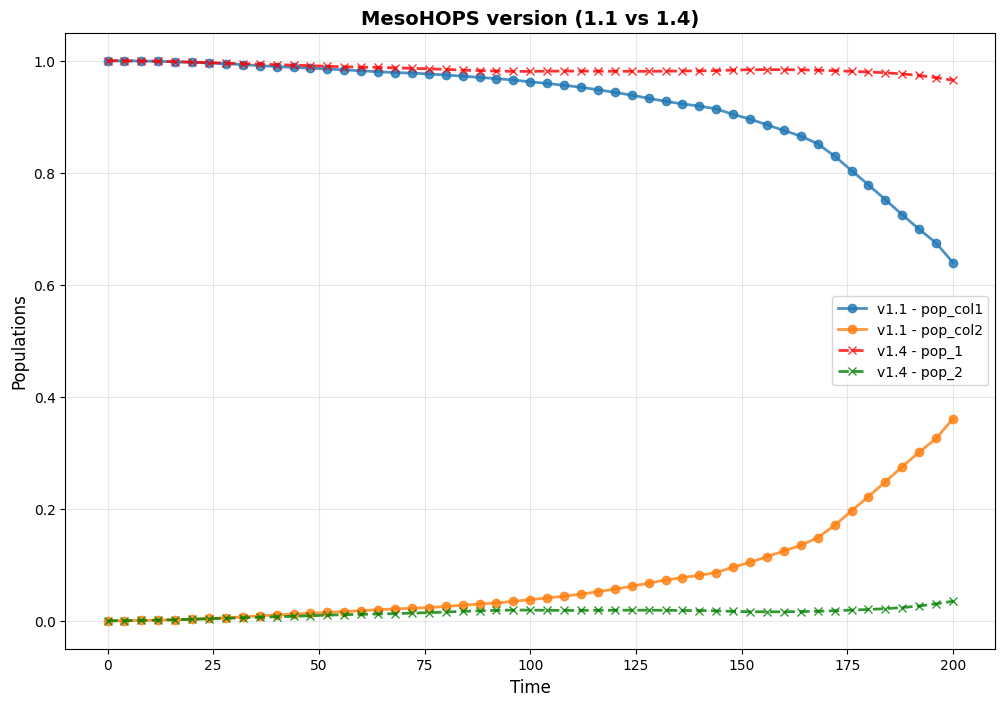

In [15]:
# Charger les données de la version 1.1 depuis le CSV
import pandas as pd
df = pd.read_csv('data.csv')

print("Données version 1.1 chargées :")
print(df.head())
print(f"\nShape des données : {df.shape}")

# Supposons que vous avez :
# pop (ndarray) : populations version 1.4, shape (n_temps, 2)
# t_axis (liste) : axe temporel commun

print(f"\nDimensions version 1.4 :")
print(f"pop shape: {pop.shape}")
print(f"t_axis length: {len(t_axis)}")

# Tracer la comparaison
plt.figure(figsize=(12, 8))

# Tracer la version 1.1 (depuis le CSV)
for i, col in enumerate(df.columns):
    if col.startswith('pop'):
        plt.plot(df['time'], df[col], marker='o', linewidth=2, 
                label=f'v1.1 - {col}', alpha=0.8)

# Tracer la version 1.4 (depuis le ndarray)
if pop.shape[1] >= 1:
    plt.plot(t_axis, pop[:, 0], 'r--', marker='x', linewidth=2, 
             label='v1.4 - pop_1', alpha=0.8)
if pop.shape[1] >= 2:
    plt.plot(t_axis, pop[:, 1], 'g--', marker='x', linewidth=2, 
             label='v1.4 - pop_2', alpha=0.8)

plt.xlabel('Time', fontsize=12)
plt.ylabel('Populations', fontsize=12)
plt.title('MesoHOPS version (1.1 vs 1.4)', fontsize=14, fontweight='bold')
plt.legend()
plt.grid(True, alpha=0.3)
plt.savefig('pop_comparison_version.png')
plt.show()

In [8]:
import numpy as np
import matplotlib.pyplot as plt

# Configuration pour les labels français
plt.rcParams['font.family'] = 'DejaVu Sans'  # Police compatible avec les caractères français

# Récupération des données de population et de l'axe temporel
pop = np.abs(hops.psi_traj)**2
t_axis = np.arange(0, 204, 4)

# Création de la figure et des axes
plt.figure(figsize=(10, 6))

# Plot des données avec légende
# Si pop a plusieurs colonnes (plusieurs états)
if pop.ndim > 1:
    for i in range(pop.shape[1]):
        plt.plot(t_axis, pop[:, i], label=f'State {i+1}')
else:
    # Si pop est un vecteur 1D
    plt.plot(t_axis, pop, label='Populations')

# Ajout de la légende
plt.legend(loc='best', frameon=True, shadow=True)

# Personnalisation des axes
plt.xlabel('Time ', fontsize=12)
plt.ylabel('Populations', fontsize=12)
plt.title('Time evolutions of each state', fontsize=14)

# Ajout de la grille pour meilleure lisibilité
plt.grid(True, alpha=0.3)

# Ajustement automatique de la mise en page
plt.tight_layout()

# Sauvegarde de la figure
plt.savefig('figs_meso.png', dpi=300, bbox_inches='tight')
plt.savefig('figs_meso.pdf', bbox_inches='tight')  # Version vectorielle

# Affichage du plot
plt.show()

AttributeError: 'HopsTrajectory' object has no attribute 'psi_traj'

In [ ]:
# Graphique des différences
plt.figure(figsize=(12, 8))

# Calculer et tracer les différences
if pop.shape[1] >= 1 and 'pop_col1' in df.columns:
    diff1 = pop[:, 0] - df['pop_col1'].values
    plt.plot(t_axis, diff1, 'ro-', label='Différence pop_col1 (v1.4 - v1.1)')

if pop.shape[1] >= 2 and 'pop_col2' in df.columns:
    diff2 = pop[:, 1] - df['pop_col2'].values
    plt.plot(t_axis, diff2, 'go-', label='Différence pop_col2 (v1.4 - v1.1)')

plt.xlabel('Time', fontsize=12)
plt.ylabel('Différence', fontsize=12)
plt.title('Différences entre MesoHOPS v1.4 et v1.1', fontsize=14, fontweight='bold')
plt.legend()
plt.grid(True, alpha=0.3)
plt.axhline(y=0, color='k', linestyle='-', alpha=0.3)
plt.show()

# Statistiques de comparaison
print("\n" + "="*50)
print("STATISTIQUES DE COMPARAISON")
print("="*50)

if pop.shape[1] >= 1 and 'pop_col1' in df.columns:
    diff1 = pop[:, 0] - df['pop_col1'].values
    print(f"Pop_col1 - Différence moyenne: {np.mean(diff1):.6f}")
    print(f"Pop_col1 - Écart-type des différences: {np.std(diff1):.6f}")
    print(f"Pop_col1 - Différence max: {np.max(np.abs(diff1)):.6f}")

if pop.shape[1] >= 2 and 'pop_col2' in df.columns:
    diff2 = pop[:, 1] - df['pop_col2'].values
    print(f"Pop_col2 - Différence moyenne: {np.mean(diff2):.6f}")
    print(f"Pop_col2 - Écart-type des différences: {np.std(diff2):.6f}")
    print(f"Pop_col2 - Différence max: {np.max(np.abs(diff2)):.6f}")

# Graphique côte à côte
fig, axes = plt.subplots(1, 2, figsize=(15, 6))

# Graphique gauche : Version 1.1
for i, col in enumerate(df.columns):
    if col.startswith('pop'):
        axes[0].plot(df['time'], df[col], marker='o', linewidth=2, label=col)

axes[0].set_xlabel('Time')
axes[0].set_ylabel('Population')
axes[0].set_title('MesoHOPS Version 1.1')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Graphique droite : Version 1.4
if pop.shape[1] >= 1:
    axes[1].plot(t_axis, pop[:, 0], marker='x', linewidth=2, label='pop_col1')
if pop.shape[1] >= 2:
    axes[1].plot(t_axis, pop[:, 1], marker='x', linewidth=2, label='pop_col2')

axes[1].set_xlabel('Time')
axes[1].set_ylabel('Population')
axes[1].set_title('MesoHOPS Version 1.4')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()